# Welcome to Computer Vision! #

Have you ever wanted to teach a computer to see? In this course, that's exactly what you'll do!

In this course, you'll:
- Use modern deep-learning networks to build an **image classifier** with Keras
- Design your own **custom convnet** with reusable blocks
- Learn the fundamental ideas behind visual **feature extraction**
- Master the art of **transfer learning** to boost your models
- Utilize **data augmentation** to extend your dataset

If you've taken the *Introduction to Deep Learning* course, you'll know everything you need to be successful.

Now let's get started!

# Introduction #

This course will introduce you to the fundamental ideas of computer vision. Our goal is to learn how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human visual system can solve.

The neural networks that are best at this task are called **convolutional neural networks** (Sometimes we say **convnet** or **CNN** instead.) Convolution is the mathematical operation that gives the layers of a convnet their unique structure. In future lessons, you'll learn why this structure is so effective at solving computer vision problems.

We will apply these ideas to the problem of **image classification**: given a picture, can we train a computer to tell us what it's a picture *of*? You may have seen [apps](https://identify.plantnet.org/) that can identify a species of plant from a photograph. That's an image classifier! In this course, you'll learn how to build image classifiers just as powerful as those used in professional applications.

While our focus will be on image classification, what you'll learn in this course is relevant to every kind of computer vision problem. At the end, you'll be ready to move on to more advanced applications like generative adversarial networks and image segmentation.

# The Convolutional Classifier #

A convnet used for image classification consists of two parts: a **convolutional base** and a **dense head**.

<center>
<!-- <img src="./images/1-parts-of-a-convnet.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">-->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/U0n5xjU.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">
</center>

The base is used to **extract the features** from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well. (You'll learn about these in the next lesson.)

The head is used to **determine the class** of the image. It is formed primarily of dense layers, but might include other layers like dropout. 

What do we mean by visual feature? A feature could be a line, a color, a texture, a shape, a pattern -- or some complicated combination.

The whole process goes something like this:

<center>
<!-- <img src="./images/1-extract-classify.png" width="600" alt="The idea of feature extraction."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/UUAafkn.png" width="600" alt="The idea of feature extraction.">
</center>

The features actually extracted look a bit different, but it gives the idea.

# Training the Classifier #

The goal of the network during training is to learn two things:
1. which features to extract from an image (base),
2. which class goes with what features (head).

These days, convnets are rarely trained from scratch. More often, we **reuse the base of a pretrained model**. To the pretrained base we then **attach an untrained head**. In other words, we reuse the part of a network that has already learned to do *1. Extract features*, and attach to it some fresh layers to learn *2. Classify*.

<center>
<!-- <img src="./images/1-attach-head-to-base.png" width="400" alt="Attaching a new head to a trained base."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/E49fsmV.png" width="400" alt="Attaching a new head to a trained base.">
</center>

Because the head usually consists of only a few dense layers, very accurate classifiers can be created from relatively little data. 

Reusing a pretrained model is a technique known as **transfer learning**. It is so effective, that almost every image classifier these days will make use of it.

# Example - Train a Convnet Classifier #

Throughout this course, we're going to be creating classifiers that attempt to solve the following problem: is this a picture of a *Car* or of a *Truck*? Our dataset is about 10,000 pictures of various automobiles, around half cars and half trucks.

## Step 1 - Load Data ##

This next hidden cell will import some libraries and set up our data pipeline. We have a training split called `ds_train` and a validation split called `ds_valid`.

In [1]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


Let's take a look at a few examples from the training set.

In [2]:

import matplotlib.pyplot as plt

## Step 2 - Define Pretrained Base ##

The most commonly used dataset for pretraining is [*ImageNet*](http://image-net.org/about-overview), a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its [`applications` module](https://www.tensorflow.org/api_docs/python/tf/keras/applications). The pretrained model we'll use is called **VGG16**.

In [3]:
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

## Step 3 - Attach Head ##

Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first `Dense` layer) followed by a layer to transform the outputs to a probability score for class 1, `Truck`. The `Flatten` layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

## Step 4 - Train ##

Finally, let's train the model. Since this is a two-class problem, we'll use the binary versions of `crossentropy` and `accuracy`. The `adam` optimizer generally performs well, so we'll choose it as well.

In [5]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

When training a neural network, it's always a good idea to examine the loss and metric plots. The `history` object contains this information in a dictionary `history.history`. We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method.

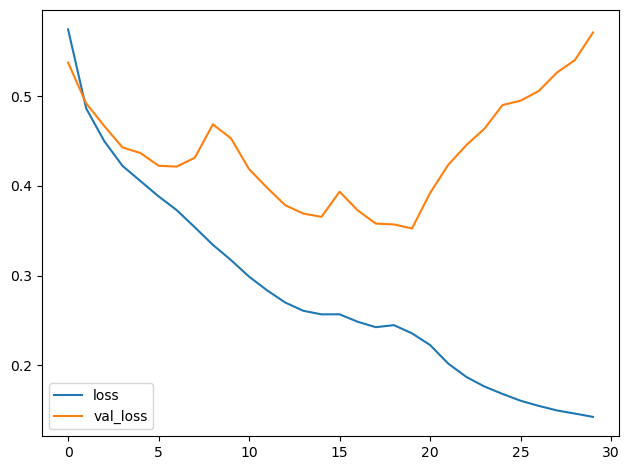

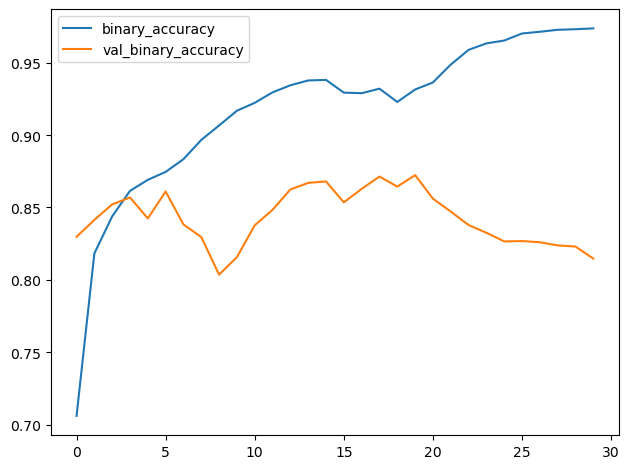

In [6]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# Conclusion #

In this lesson, we learned about the structure of a convnet classifier: a **head** to act as a classifier atop of a **base** which performs the feature extraction.

The head, essentially, is an ordinary classifier like you learned about in the introductory course. For features, it uses those features extracted by the base. This is the basic idea behind convolutional classifiers: that we can attach a unit that performs feature engineering to the classifier itself.

This is one of the big advantages deep neural networks have over traditional machine learning models: given the right network structure, the deep neural net can learn how to engineer the features it needs to solve its problem.

For the next few lessons, we'll take a look at how the convolutional base accomplishes the feature extraction. Then, you'll learn how to apply these ideas and design some classifiers of your own.

# Your Turn #

For now, move on to the [**Exercise**](https://www.kaggle.com/kernels/fork/10781907) and build your own image classifier!

----


# Topic 2: What is Convolution & Relu Revisted

<!--TITLE: Convolution and ReLU-->

In [1]:

import numpy as np
from itertools import product

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

# Introduction #

In the last lesson, we saw that a convolutional classifier has two parts: a convolutional **base** and a **head** of dense layers. We learned that the job of the base is to extract visual features from an image, which the head would then use to classify the image.

Over the next few lessons, we're going to learn about the two most important types of layers that you'll usually find in the base of a convolutional image classifier. These are the **convolutional layer** with **ReLU activation**, and the **maximum pooling layer**. In Lesson 5, you'll learn how to design your own convnet by composing these layers into blocks that perform the feature extraction.

This lesson is about the convolutional layer with its ReLU activation function.

# Feature Extraction #

Before we get into the details of convolution, let's discuss the *purpose* of these layers in the network. We're going to see how these three operations (convolution, ReLU, and maximum pooling) are used to implement the feature extraction process.

The **feature extraction** performed by the base consists of **three basic operations**:
1. **Filter** an image for a particular feature (convolution)
2. **Detect** that feature within the filtered image (ReLU)
3. **Condense** the image to enhance the features (maximum pooling)

The next figure illustrates this process. You can see how these three operations are able to isolate some particular characteristic of the original image (in this case, horizontal lines).

<figure>
<!-- <img src="./images/2-show-extraction.png" width="1200" alt="An example of the feature extraction process."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/IYO9lqp.png" width="600" alt="An example of the feature extraction process.">
<figcaption style="textalign: center; font-style: italic"><center>The three steps of feature extraction.</center></figcaption>
</figure>

Typically, the network will perform several extractions in parallel on a single image. In modern convnets, it's not uncommon for the final layer in the base to be producing over 1000 unique visual features.

# Filter with Convolution #

A convolutional layer carries out the filtering step. You might define a convolutional layer in a Keras model something like this:

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    # More layers follow
])

We can understand these parameters by looking at their relationship to the *weights* and *activations* of the layer. Let's do that now.

## Weights ##

The **weights** a convnet learns during training are primarily contained in its convolutional layers. These weights we call **kernels**. We can represent them as small arrays:

<figure>
<!-- <img src="./images/3-kernel.png" width="150" alt="A 3x3 kernel."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/uJfD9r9.png" width="150" alt="A 3x3 kernel.">
</figure>

A kernel operates by scanning over an image and producing a *weighted sum* of pixel values. In this way, a kernel will act sort of like a polarized lens, emphasizing or deemphasizing certain patterns of information.

<figure>
<!-- <img src="./images/3-kernel-lens.png" width="400" alt="A kernel acts as a kind of lens."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/j3lk26U.png" width="250" alt="A kernel acts as a kind of lens.">
<figcaption style="textalign: center; font-style: italic"><center>A kernel acts as a kind of lens.</center></figcaption>
</figure>

Kernels define how a convolutional layer is connected to the layer that follows. The kernel above will connect each neuron in the output to nine neurons in the input. By setting the dimensions of the kernels with `kernel_size`, you are telling the convnet how to form these connections. Most often, a kernel will have odd-numbered dimensions -- like `kernel_size=(3, 3)` or `(5, 5)` -- so that a single pixel sits at the center, but this is not a requirement.

The kernels in a convolutional layer determine what kinds of features it creates. During training, a convnet tries to learn what features it needs to solve the classification problem. This means finding the best values for its kernels.

<!--TODO: Learning a kernel-->

## Activations ##

The **activations** in the network we call **feature maps**. They are what result when we apply a filter to an image; they contain the visual features the kernel extracts. Here are a few kernels pictured with feature maps they produced.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/JxBwchH.png" width="800" alt="Three kernels and the feature maps they produce."><figcaption style="textalign: center; font-style: italic"><center>Kernels and features.</center></figcaption>
</figure>

From the pattern of numbers in the kernel, you can tell the kinds of feature maps it creates. Generally, what a convolution accentuates in its inputs will match the shape of the *positive* numbers in the kernel. The left and middle kernels above will both filter for horizontal shapes.

With the `filters` parameter, you tell the convolutional layer how many feature maps you want it to create as output.

# Detect with ReLU #

After filtering, the feature maps pass through the activation function. The **rectifier function** has a graph like this:

<figure>
<!-- <img src="./images/relu.png" width="300" alt=""> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/DxGJuTH.png" width="300" alt="Graph of the ReLU activation function.">
<figcaption style="textalign: center; font-style: italic"><center>The graph of the rectifier function looks like a line with the negative part "rectified" to 0.</center></figcaption>
</figure>

A neuron with a rectifier attached is called a *rectified linear unit*. For that reason, we might also call the rectifier function the **ReLU activation** or even the ReLU function.

The ReLU activation can be defined in its own `Activation` layer, but most often you'll just include it as the activation function of `Conv2D`.

In [3]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
    # More layers follow
])

You could think about the activation function as scoring pixel values according to some measure of importance. The ReLU activation says that negative values are not important and so sets them to 0. ("Everything unimportant is equally unimportant.")

Here is ReLU applied the feature maps above. Notice how it succeeds at isolating the features.

<figure>
<!-- <img src="./images/3-relu-and-maps.png" width="800" alt="ReLU applied to feature maps."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/dKtwzPY.png" width="800" alt="ReLU applied to feature maps.">
</figure>

Like other activation functions, the ReLU function is **nonlinear**. Essentially this means that the total effect of all the layers in the network becomes different than what you would get by just adding the effects together -- which would be the same as what you could achieve with only a single layer. The nonlinearity ensures features will combine in interesting ways as they move deeper into the network. (We'll explore this "feature compounding" more in Lesson 5.)

# Example - Apply Convolution and ReLU #

We'll do the extraction ourselves in this example to understand better what convolutional networks are doing "behind the scenes".

Here is the image we'll use for this example:

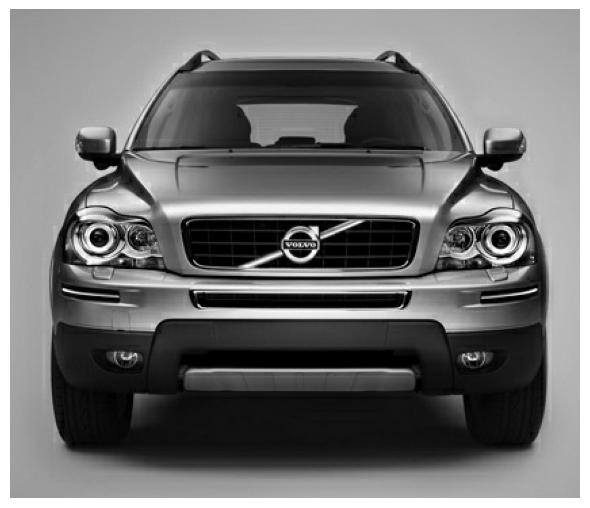

In [4]:

import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = '../input/computer-vision-resources/car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show()

For the filtering step, we'll define a kernel and then apply it with the convolution. The kernel in this case is an "edge detection" kernel. You can define it with `tf.constant` just like you'd define an array in Numpy with `np.array`. This creates a *tensor* of the sort TensorFlow uses.

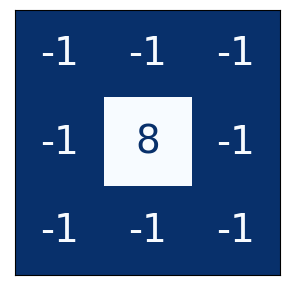

In [5]:
import tensorflow as tf

kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)

TensorFlow includes many common operations performed by neural networks in its `tf.nn` [module](https://www.tensorflow.org/api_docs/python/tf/nn). The two that we'll use are `conv2d` and `relu`. These are simply function versions of Keras layers.

This next hidden cell does some reformatting to make things compatible with TensorFlow. The details aren't important for this example.

In [6]:

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

Now let's apply our kernel and see what happens.

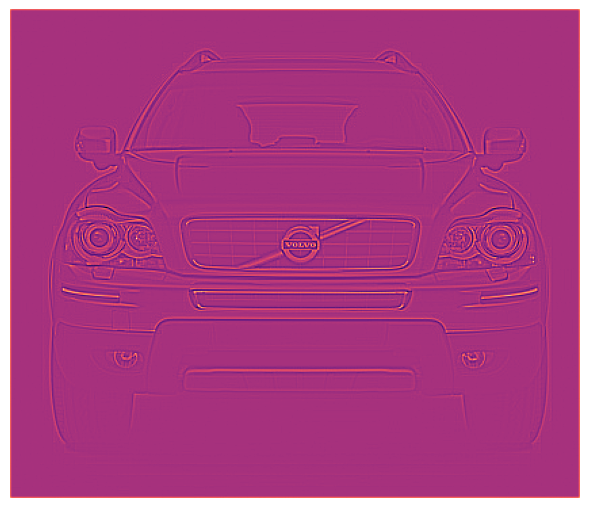

In [7]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two in lesson 4!
    strides=1,
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

Next is the detection step with the ReLU function. This function is much simpler than the convolution, as it doesn't have any parameters to set.

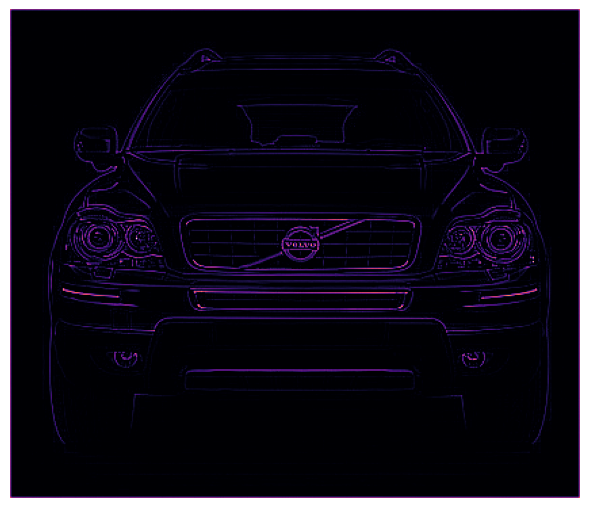

In [8]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

And now we've created a feature map! Images like these are what the head uses to solve its classification problem. We can imagine that certain features might be more characteristic of *Cars* and others more characteristic of *Trucks*. The task of a convnet during training is to create kernels that can find those features.

# Conclusion #

We saw in this lesson the first two steps a convnet uses to perform feature extraction: **filter** with `Conv2D` layers and **detect** with `relu` activation.

# Your Turn #

In [**the exercises**](https://www.kaggle.com/kernels/fork/11989557), you'll have a chance to experiment with the kernels in the pretrained VGG16 model we used in Lesson 1.

----


# Topic 3: Max Pooling

<!--TITLE: Maximum Pooling-->
# Introduction #

In Lesson 2 we began our discussion of how the base in a convnet performs feature extraction. We learned about how the first two operations in this process occur in a `Conv2D` layer with `relu` activation.

In this lesson, we'll look at the third (and final) operation in this sequence: **condense** with **maximum pooling**, which in Keras is done by a `MaxPool2D` layer.

# Condense with Maximum Pooling #

Adding condensing step to the model we had before, will give us this:

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # More layers follow
])

A `MaxPool2D` layer is much like a `Conv2D` layer, except that it uses a simple maximum function instead of a kernel, with the `pool_size` parameter analogous to `kernel_size`. A `MaxPool2D` layer doesn't have any trainable weights like a convolutional layer does in its kernel, however.

Let's take another look at the extraction figure from the last lesson. Remember that `MaxPool2D` is the **Condense** step.

<figure>
<!-- <img src="./images/2-show-extraction.png" width="1200" alt="An example of the feature extraction process."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/IYO9lqp.png" width="600" alt="An example of the feature extraction process.">
</figure>

Notice that after applying the ReLU function (**Detect**) the feature map ends up with a lot of "dead space," that is, large areas containing only 0's (the black areas in the image). Having to carry these 0 activations through the entire network would increase the size of the model without adding much useful information. Instead, we would like to *condense* the feature map to retain only the most useful part -- the feature itself.

This in fact is what **maximum pooling** does. Max pooling takes a patch of activations in the original feature map and replaces them with the maximum activation in that patch.

<figure>
<!-- <img src="./images/3-max-pooling.png" width="600" alt="Maximum pooling replaces a patch with the maximum value in that patch."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/hK5U2cd.png" width="400" alt="Maximum pooling replaces a patch with the maximum value in that patch.">
</figure>

When applied after the ReLU activation, it has the effect of "intensifying" features. The pooling step increases the proportion of active pixels to zero pixels.

# Example - Apply Maximum Pooling #

Let's add the "condense" step to the feature extraction we did in the example in Lesson 2. This next hidden cell will take us back to where we left off.

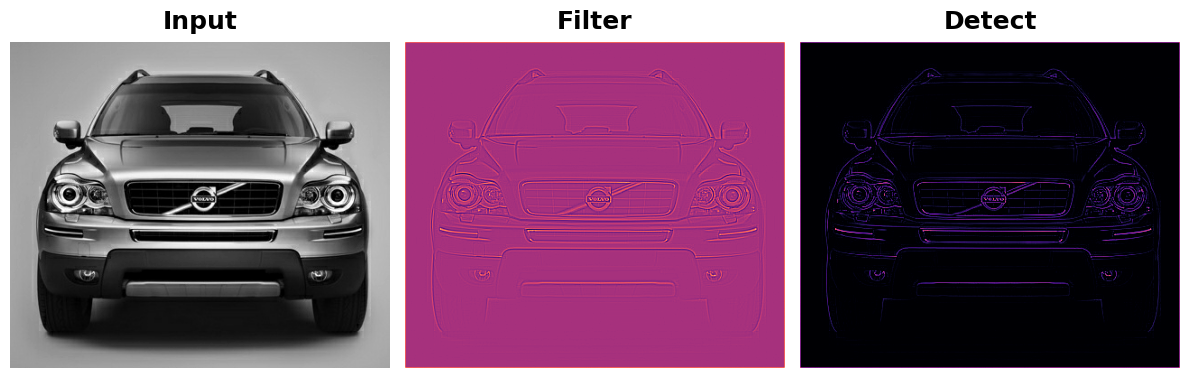

In [2]:

import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Read image
image_path = '../input/computer-vision-resources/car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

# Define kernel
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=tf.float32)

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

# Filter step
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two in the next lesson!
    strides=1,
    padding='SAME'
)

# Detect step
image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

We'll use another one of the functions in `tf.nn` to apply the pooling step, `tf.nn.pool`. This is a Python function that does the same thing as the `MaxPool2D` layer you use when model building, but, being a simple function, is easier to use directly.

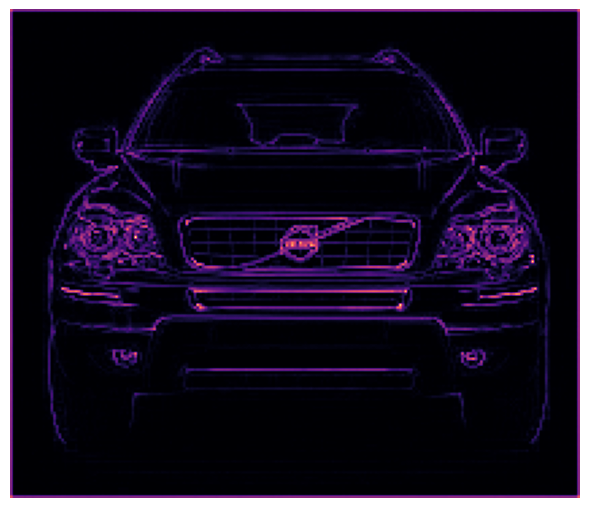

In [3]:
import tensorflow as tf

image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

Pretty cool! Hopefully you can see how the pooling step was able to intensify the feature by condensing the image around the most active pixels.

# Translation Invariance #

We called the zero-pixels "unimportant". Does this mean they carry no information at all? In fact, the zero-pixels carry *positional information*. The blank space still positions the feature within the image. When `MaxPool2D` removes some of these pixels, it removes some of the positional information in the feature map. This gives a convnet a property called **translation invariance**. This means that a convnet with maximum pooling will tend not to distinguish features by their *location* in the image. ("Translation" is the mathematical word for changing the position of something without rotating it or changing its shape or size.)

Watch what happens when we repeatedly apply maximum pooling to the following feature map.

<figure>
<!-- <img src="./images/4-two-dots.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/97j8WA1.png" width="800" alt="Pooling tends to destroy positional information.">
</figure>

The two dots in the original image became indistinguishable after repeated pooling. In other words, pooling destroyed some of their positional information. Since the network can no longer distinguish between them in the feature maps, it can't distinguish them in the original image either: it has become *invariant* to that difference in position.

In fact, pooling only creates translation invariance in a network *over small distances*, as with the two dots in the image. Features that begin far apart will remain distinct after pooling; only *some* of the positional information was lost, but not all of it.

<figure>
<!-- <img src="./images/4-two-dots-2.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/kUMWdcP.png" width="800" alt="But only over small distances. Two dots far apart stay separated">
</figure>

This invariance to small differences in the positions of features is a nice property for an image classifier to have. Just because of differences in perspective or framing, the same kind of feature might be positioned in various parts of the original image, but we would still like for the classifier to recognize that they are the same. Because this invariance is *built into* the network, we can get away with using much less data for training: we no longer have to teach it to ignore that difference. This gives convolutional networks a big efficiency advantage over a network with only dense layers. (You'll see another way to get invariance for free in **Lesson 6** with **Data Augmentation**!)

# Conclusion #

In this lesson, we learned the about the last step of feature extraction: **condense** with `MaxPool2D`. In Lesson 4, we'll finish up our discussion of convolution and pooling with *sliding windows*.

# Your Turn #

Now, start the [**Exercise**](https://www.kaggle.com/kernels/fork/11989559) to finish the extraction you started in Lesson 2, see this invariance property in action, and also learn about another kind of pooling: **average pooling**!

----


# Topic 4: The Sliding Window

In [1]:

import numpy as np
from itertools import product
from skimage import draw, transform

def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # Create Layers
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # Extract Feature
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

# Introduction #

In the previous two lessons, we learned about the three operations that carry out feature extraction from an image:
1. *filter* with a **convolution** layer
2. *detect* with **ReLU** activation
3. *condense* with a **maximum pooling** layer

The convolution and pooling operations share a common feature: they are both performed over a **sliding window**. With convolution, this "window" is given by the dimensions of the kernel, the parameter `kernel_size`. With pooling, it is the pooling window, given by `pool_size`.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/LueNK6b.gif" width=400 alt="A 2D sliding window.">
</figure>

There are two additional parameters affecting both convolution and pooling layers -- these are the `strides` of the window and whether to use `padding` at the image edges. The `strides` parameter says how far the window should move at each step, and the `padding` parameter describes how we handle the pixels at the edges of the input.

With these two parameters, defining the two layers becomes:

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=2,
                     strides=1,
                     padding='same')
    # More layers follow
])

# Stride #

The distance the window moves at each step is called the **stride**. We need to specify the stride in both dimensions of the image: one for moving left to right and one for moving top to bottom. This animation shows `strides=(2, 2)`, a movement of 2 pixels each step.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Tlptsvt.gif" width=400 alt="Sliding window with a stride of (2, 2).">
</figure>

What effect does the stride have? Whenever the stride in either direction is greater than 1, the sliding window will skip over some of the pixels in the input at each step.

Because we want high-quality features to use for classification, convolutional layers will most often have `strides=(1, 1)`. Increasing the stride means that we miss out on potentially valuble information in our summary. Maximum pooling layers, however, will almost always have stride values greater than 1, like `(2, 2)` or `(3, 3)`, but not larger than the window itself.

Finally, note that when the value of the `strides` is the same number in both directions, you only need to set that number; for instance, instead of `strides=(2, 2)`, you could use `strides=2` for the parameter setting.

# Padding #

When performing the sliding window computation, there is a question as to what to do at the boundaries of the input. Staying entirely inside the input image means the window will never sit squarely over these boundary pixels like it does for every other pixel in the input. Since we aren't treating all the pixels exactly the same, could there be a problem?

What the convolution does with these boundary values is determined by its `padding` parameter. In TensorFlow, you have two choices: either `padding='same'` or `padding='valid'`. There are trade-offs with each.

When we set `padding='valid'`, the convolution window will stay entirely inside the input. The drawback is that the output shrinks (loses pixels), and shrinks more for larger kernels. This will limit the number of layers the network can contain, especially when inputs are small in size.

The alternative is to use `padding='same'`. The trick here is to **pad** the input with 0's around its borders, using just enough 0's to make the size of the output the *same* as the size of the input. This can have the effect however of diluting the influence of pixels at the borders. The animation below shows a sliding window with `'same'` padding.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/RvGM2xb.gif" width=400 alt="Illustration of zero (same) padding.">
</figure>

The VGG model we've been looking at uses `same` padding for all of its convolutional layers. Most modern convnets will use some combination of the two. (Another parameter to tune!)

# Example - Exploring Sliding Windows #

To better understand the effect of the sliding window parameters, it can help to observe a feature extraction on a low-resolution image so that we can see the individual pixels. Let's just look at a simple circle.

This next hidden cell will create an image and kernel for us.

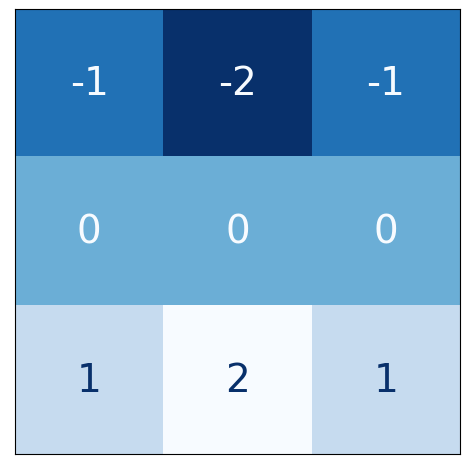

In [3]:

import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])
# Bottom sobel
kernel = tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

show_kernel(kernel)

The VGG architecture is fairly simple. It uses convolution with strides of 1 and maximum pooling with $2 \times 2$ windows and strides of 2. We've included a function in the `visiontools` utility script that will show us all the steps.

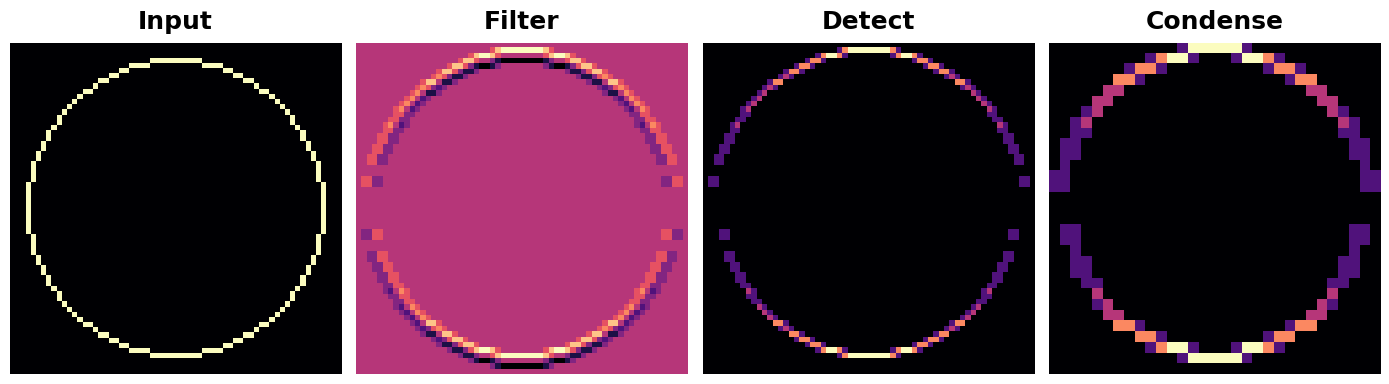

In [4]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=1,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),
)

And that works pretty well! The kernel was designed to detect horizontal lines, and we can see that in the resulting feature map the more horizontal parts of the input end up with the greatest activation.

What would happen if we changed the strides of the convolution to 3?

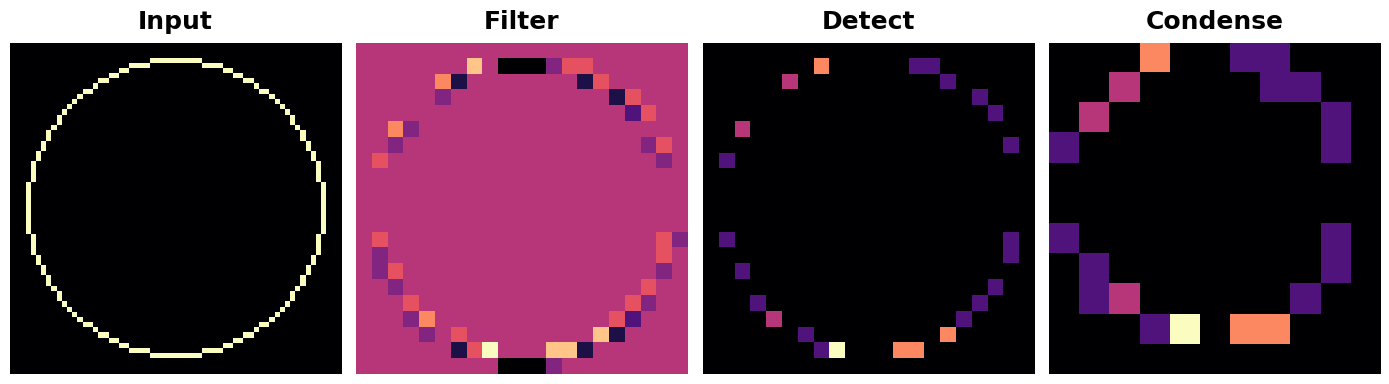

In [5]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=3,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),    
)

This seems to reduce the quality of the feature extracted. Our input circle is rather "finely detailed," being only 1 pixel wide. A convolution with strides of 3 is too coarse to produce a good feature map from it.

Sometimes, a model will use a convolution with a larger stride in it's initial layer. This will usually be coupled with a larger kernel as well. The ResNet50 model, for instance, uses $7 \times 7$ kernels with strides of 2 in its first layer. This seems to accelerate the production of large-scale features without the sacrifice of too much information from the input.

# Conclusion #

In this lesson, we looked at a characteristic computation common to both convolution and pooling: the **sliding window** and the parameters affecting its behavior in these layers. This style of windowed computation contributes much of what is characteristic of convolutional networks and is an essential part of their functioning.

# Your Turn #

Move on to the [**Exercise**](https://www.kaggle.com/kernels/fork/12400209) where you'll explore sliding windows, learn about how *stacking* convolutional layers can increase the effective window size, and also learn about how convolution can be used with *one-dimensional* data, like time series.

----


# Topic 5: Custom Convnet

<!--TITLE:Custom Convnets-->
# Introduction #

Now that you've seen the layers a convnet uses to extract features, it's time to put them together and build a network of your own!

# Simple to Refined #

In the last three lessons, we saw how convolutional networks perform **feature extraction** through three operations: **filter**, **detect**, and **condense**. A single round of feature extraction can only extract relatively simple features from an image, things like simple lines or contrasts. These are too simple to solve most classification problems. Instead, convnets will repeat this extraction over and over, so that the features become more complex and refined as they travel deeper into the network.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/VqmC1rm.png" alt="Features extracted from an image of a car, from simple to refined." width=800>
</figure>

# Convolutional Blocks #

It does this by passing them through long chains of **convolutional blocks** which perform this extraction.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/pr8VwCZ.png" width="400" alt="Extraction as a sequence of blocks.">
</figure>

These convolutional blocks are stacks of `Conv2D` and `MaxPool2D` layers, whose role in feature extraction we learned about in the last few lessons.

<figure>
<!-- <img src="./images/2-block-crp.png" width="400" alt="A kind of extraction block: convolution, ReLU, pooling."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/8D6IhEw.png" width="400" alt="A kind of extraction block: convolution, ReLU, pooling.">
</figure>

Each block represents a round of extraction, and by composing these blocks the convnet can combine and recombine the features produced, growing them and shaping them to better fit the problem at hand. The deep structure of modern convnets is what allows this sophisticated feature engineering and has been largely responsible for their superior performance.

# Example - Design a Convnet #

Let's see how to define a deep convolutional network capable of engineering complex features. In this example, we'll create a Keras `Sequence` model and then train it on our Cars dataset.

## Step 1 - Load Data ##

This hidden cell loads the data.

In [1]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


## Step 2 - Define Model ##

Here is a diagram of the model we'll use:

<figure>
<!-- <img src="./images/2-convmodel-1.png" width="200" alt="Diagram of a convolutional model."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/U1VdoDJ.png" width="250" alt="Diagram of a convolutional model.">
</figure>

Now we'll define the model. See how our model consists of three blocks of `Conv2D` and `MaxPool2D` layers (the base) followed by a head of `Dense` layers. We can translate this diagram more or less directly into a Keras `Sequential` model just by filling in the appropriate parameters.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

Notice in this definition is how the number of filters doubled block-by-block: 32, 64, 128. This is a common pattern. Since the `MaxPool2D` layer is reducing the *size* of the feature maps, we can afford to increase the *quantity* we create.

## Step 3 - Train ##

We can train this model just like the model from Lesson 1: compile it with an optimizer along with a loss and metric appropriate for binary classification.

In [3]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=40,
    verbose=0,
)


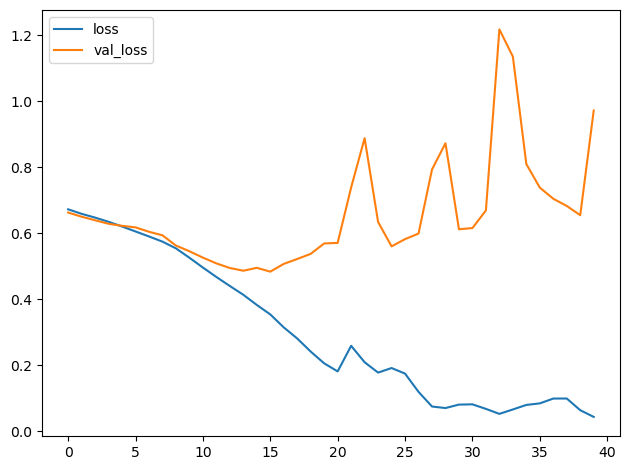

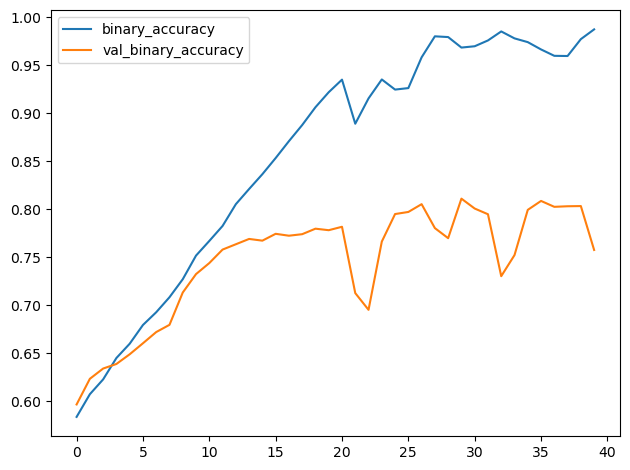

In [4]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

This model is much smaller than the VGG16 model from Lesson 1 -- only 3 convolutional layers versus the 16 of VGG16. It was nevertheless able to fit this dataset fairly well. We might still be able to improve this simple model by adding more convolutional layers, hoping to create features better adapted to the dataset. This is what we'll try in the exercises.

# Conclusion #

In this tutorial, you saw how to build a custom convnet composed of many **convolutional blocks** and capable of complex feature engineering. 

# Your Turn #

In the exercises, you'll create a convnet that performs as well on this problem as VGG16 does -- without pretraining! [**Try it now!**](https://www.kaggle.com/kernels/fork/11989565)

----


# Final Topic: Augmenting our Data

<!--TITLE:Data Augmentation-->

# Introduction #

Now that you've learned the fundamentals of convolutional classifiers, you're ready to move on to more advanced topics.

In this lesson, you'll learn a trick that can give a boost to your image classifiers: it's called **data augmentation**. 

# The Usefulness of Fake Data #

The best way to improve the performance of a machine learning model is to train it on more data. The more examples the model has to learn from, the better it will be able to recognize which differences in images matter and which do not. More data helps the model to *generalize* better.

One easy way of getting more data is to use the data you already have. If we can transform the images in our dataset in ways that preserve the class, we can teach our classifier to ignore those kinds of transformations. For instance, whether a car is facing left or right in a photo doesn't change the fact that it is a *Car* and not a *Truck*. So, if we **augment** our training data with flipped images, our classifier will learn that "left or right" is a difference it should ignore.

And that's the whole idea behind data augmentation: add in some extra fake data that looks reasonably like the real data and your classifier will improve.

# Using Data Augmentation #

Typically, many kinds of transformation are used when augmenting a dataset. These might include rotating the image, adjusting the color or contrast, warping the image, or many other things, usually applied in combination. Here is a sample of the different ways a single image might be transformed.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/UaOm0ms.png" width=400, alt="Sixteen transformations of a single image of a car.">
</figure>

Data augmentation is usually done *online*, meaning, as the images are being fed into the network for training. Recall that training is usually done on mini-batches of data. This is what a batch of 16 images might look like when data augmentation is used.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/MFviYoE.png" width=400, alt="A batch of 16 images with various random transformations applied.">
</figure>

Each time an image is used during training, a new random transformation is applied. This way, the model is always seeing something a little different than what it's seen before. This extra variance in the training data is what helps the model on new data.

It's important to remember though that not every transformation will be useful on a given problem. Most importantly, whatever transformations you use should not mix up the classes. If you were training a [digit recognizer](https://www.kaggle.com/c/digit-recognizer), for instance, rotating images would mix up '9's and '6's. In the end, the best approach for finding good augmentations is the same as with most ML problems: try it and see!

# Example - Training with Data Augmentation #

Keras lets you augment your data in two ways. The first way is to include it in the data pipeline with a function like [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). The second way is to include it in the model definition by using Keras's **preprocessing layers**. This is the approach that we'll take. The primary advantage for us is that the image transformations will be computed on the GPU instead of the CPU, potentially speeding up training.

In this exercise, we'll learn how to improve the classifier from Lesson 1 through data augmentation. This next hidden cell sets up the data pipeline.

In [1]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


## Step 2 - Define Model ##

To illustrate the effect of augmentation, we'll just add a couple of simple transformations to the model from Tutorial 1.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
# these are a new feature in TF 2.2
from tensorflow.keras.layers.experimental import preprocessing


pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5), # contrast change by up to 50%
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

## Step 3 - Train and Evaluate ##

And now we'll start the training!

In [3]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

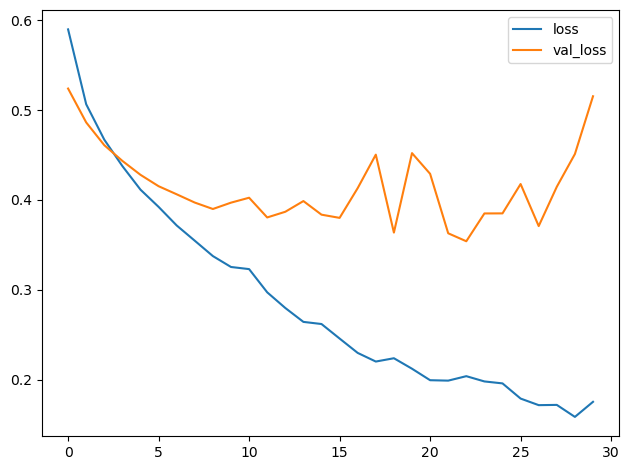

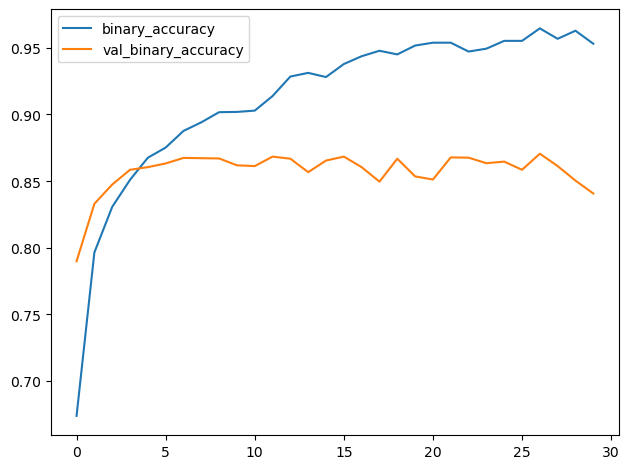

In [4]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

The training and validation curves in the model from Tutorial 1 diverged fairly quickly, suggesting that it could benefit from some regularization. The learning curves for this model were able to stay closer together, and we achieved some modest improvement in validation loss and accuracy. This suggests that the dataset did indeed benefit from the augmentation.

# Your Turn #

Move on to the [**Exercise**](https://www.kaggle.com/kernels/fork/11991328) to apply data augmentation to the custom convnet you built in Lesson 5. This will be your best model ever!